In [2]:
import sys
sys.path.append('/home/rodrigo/Desktop/thesis/code/turbofan/')

import helper
from helper import *

%matplotlib inline


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/home/rodrigo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/rodrigo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
datasets = []

path = '/home/rodrigo/datadrive/Turbofan_Engine/raw_data/' #path to .txt files

text_files = [f for f in os.listdir(path) if f.endswith('.txt') and not f.startswith('r')]

dataframe = [os.path.splitext(f)[0] for f in text_files]

sensor_columns = ["sensor {}".format(s) for s in range(1,22)]

info_columns = ['dataset_id', 'unit_id','cycle','setting 1', 'setting 2', 'setting 3']

label_columns = ['dataset_id', 'unit_id', 'rul']

settings = ['setting 1', 'setting 2', 'setting 3']

test_data = []
train_data = []
RUL_data = []

for file in text_files:
    print(file)
    
    if re.match('RUL*', file):
        subset_df = pd.read_csv(path+file, delimiter=r"\s+", header=None)
        unit_id = range(1, subset_df.shape[0] + 1)
        subset_df.insert(0, 'unit_id', unit_id)
        dataset_id = basename(file).split("_")[1][:5]
        subset_df.insert(0, 'dataset_id', dataset_id)    
        RUL_data.append(subset_df)
    
    if re.match('test*', file):
        subset_df = pd.read_csv(path+file, delimiter=r"\s+", header=None, usecols=range(26))
        dataset_id = basename(file).split("_")[1][:5]
        subset_df.insert(0, 'dataset_id', dataset_id)  
        test_data.append(subset_df)
    
    if re.match('train*', file):
        subset_df = pd.read_csv(path+file, delimiter=r"\s+", header=None, usecols=range(26))  
        dataset_id = basename(file).split("_")[1][:5]
        subset_df.insert(0, 'dataset_id', dataset_id)   
        train_data.append(subset_df)


df_train = pd.concat(train_data, ignore_index=True)
df_train.columns = info_columns + sensor_columns               
df_train.sort_values(by=['dataset_id', 'unit_id', 'cycle'], inplace=True)

df_test = pd.concat(test_data, ignore_index=True)
df_test.columns = info_columns + sensor_columns
df_test.sort_values(by=['dataset_id', 'unit_id', 'cycle'], inplace=True)

df_RUL = pd.concat(RUL_data, ignore_index=True)
df_RUL.columns = label_columns
df_RUL.sort_values(by=['dataset_id', 'unit_id'], inplace=True)

RUL_train = df_train.groupby(['dataset_id', 'unit_id'])['cycle'].max()
RUL_test = df_test.groupby(['dataset_id', 'unit_id'])['cycle'].max() + df_RUL.groupby(['dataset_id', 'unit_id'])['rul'].max()

df_train['RUL'] = df_train.apply(lambda r: get_RUL(r, RUL_train), axis=1)
df_test['RUL'] = df_test.apply(lambda r: get_RUL(r, RUL_test), axis=1)

train_FD003.txt
RUL_FD001.txt
RUL_FD004.txt
test_FD004.txt
train_FD004.txt
RUL_FD002.txt
RUL_FD003.txt
test_FD003.txt
test_FD002.txt
train_FD001.txt
train_FD002.txt
test_FD001.txt


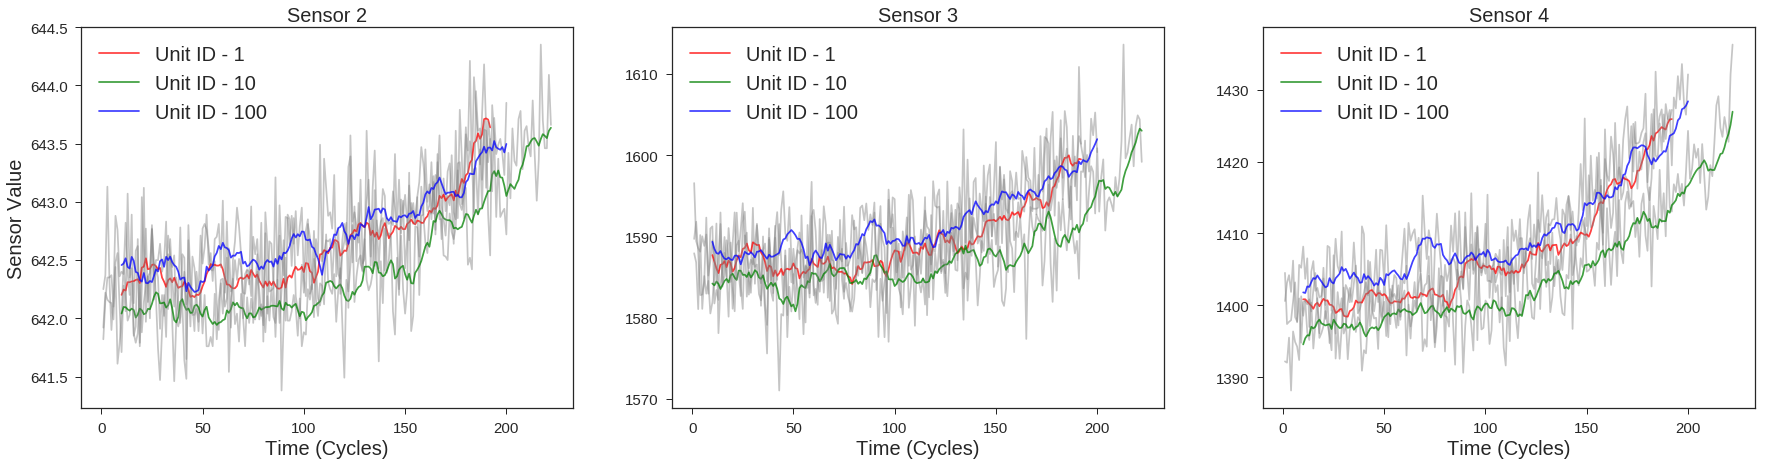

In [128]:
Dataset_ID = 'FD001' # FD001, FD002, FD003, FD004
Unit_ID = 1 # Unit_ID from specific Datast

example_slice = df_train[(df_train.dataset_id == Dataset_ID) & (df_train.unit_id == 1)]
example_slice2 = df_train[(df_train.dataset_id == Dataset_ID) & (df_train.unit_id == 10)]
example_slice3 = df_train[(df_train.dataset_id == Dataset_ID) & (df_train.unit_id == 100)]

fig, axes = plt.subplots(1, 3, figsize=(30, 7))

import pylab as plot
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plot.rcParams.update(params)


for i in range(3):
    sensor_col = sensor_columns[i+1]
    example_slice.plot(x='cycle', y=sensor_col, alpha=0.45, ax=axes[i], color='gray', legend=False);
    example_slice.rolling(window=10, on='cycle').mean().plot(x='cycle', y=sensor_col, alpha=.75, ax=axes[i], color='Red', legend=True, fontsize=15, label='Unit ID - 1');
    
    example_slice2.plot(x='cycle', y=sensor_col, alpha=0.45, ax=axes[i], color='gray', legend=False);
    example_slice2.rolling(window=10, on='cycle').mean().plot(x='cycle', y=sensor_col, alpha=.75, ax=axes[i], color='Green', legend=True, fontsize=15,label='Unit ID - 10');

    example_slice3.plot(x='cycle', y=sensor_col, alpha=0.45, ax=axes[i], color='gray', legend=False);
    example_slice3.rolling(window=10, on='cycle').mean().plot(x='cycle', y=sensor_col, alpha=.75, ax=axes[i], color='Blue', legend=True, fontsize=15,label='Unit ID - 100');
    if i == 0:
        axes[i].set_ylabel("Sensor Value", size=20);
    
    axes[i].set_xlabel("Time (Cycles)", size=20);
    axes[i].set_title(sensor_col.title(), size=20);
    


/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


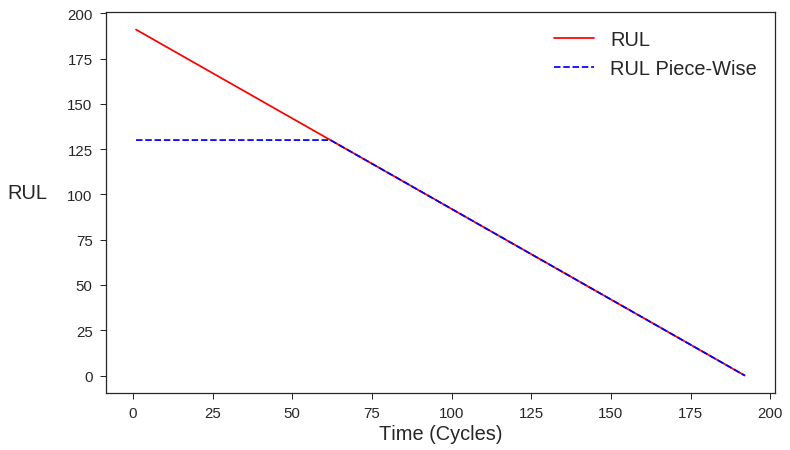

In [148]:
Dataset_ID = 'FD001' # FD001, FD002, FD003, FD004
Unit_ID = 1 # Unit_ID from specific Datast


example_slice = df_train[(df_train.dataset_id == Dataset_ID) & (df_train.unit_id == 1)]

example_slice['RUL Piece-Wise'] = example_slice.apply(lambda r: RUL_by_parts(r, 130), axis=1)




fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7))


ax.plot(example_slice['cycle'],example_slice['RUL'], label='RUL', color='red')
ax.plot(example_slice['cycle'],example_slice['RUL Piece-Wise'], '--',label='RUL Piece-Wise', color='Blue')

# gca stands for 'get current axis'

ax.axes.set_xlabel('Time (Cycles)', fontsize=20)
ax.axes.set_ylabel('RUL', fontsize=20, rotation=0, labelpad = 40)

ax.legend(loc='upper right', fontsize=20, shadow=False)

plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

In [4]:
indexes = np.arange(len(df_train.set_index(['dataset_id', 'unit_id']).index.to_series().unique()))

from sklearn.model_selection import KFold

split = KFold(n_splits=2, shuffle=True)

cv = []
cv_val = []

for train_index, test_index in split.split(indexes):
    cv.append(train_index)
    cv_val.append(test_index)

In [5]:
idx_train = df_train.set_index(['dataset_id', 'unit_id']).index.to_series().unique()[cv[0]]
idx_valid = df_train.set_index(['dataset_id', 'unit_id']).index.to_series().unique()[cv_val[0]]

train = df_train.set_index(['dataset_id', 'unit_id']).loc[idx_train]
validation = df_train.set_index(['dataset_id', 'unit_id']).loc[idx_valid]

clusterer = hdbscan.HDBSCAN(min_cluster_size=400, prediction_data=True).fit(train[['setting 1', 'setting 2', 'setting 3']])

train_labels, strengths = hdbscan.approximate_predict(clusterer, train[['setting 1', 'setting 2', 'setting 3']])
valid_labels, strengths = hdbscan.approximate_predict(clusterer, validation[['setting 1', 'setting 2', 'setting 3']])

train['HDBScan'] = train_labels
validation['HDBScan'] = valid_labels

type_1 = ['FD001', 'FD003']
type_2 = ['FD002', 'FD004']

df_train_type1 = train.loc[type_1]
df_train_type2 = train.loc[type_2]

df_validation_type1 = validation.loc[type_1]
df_validation_type2 = validation.loc[type_2]

df_train_type1_normalize = df_train_type1.copy()
df_validation_type1_normalize = df_validation_type1.copy()

scaler_type1 = StandardScaler().fit(df_train_type1[sensor_columns])

df_train_type1_normalize[sensor_columns] = scaler_type1.transform(df_train_type1[sensor_columns])
df_validation_type1_normalize[sensor_columns] = scaler_type1.transform(df_validation_type1[sensor_columns])

df_train_type1 = df_train_type1_normalize.copy()
df_validation_type1 = df_validation_type1_normalize.copy()

del(df_train_type1_normalize, df_validation_type1_normalize)

df_train_type2_normalize = df_train_type2.copy()
df_validtion_type2_normalize = df_validation_type2.copy()

gb = df_train_type2.groupby('HDBScan')[sensor_columns]

d={}

for x in gb.groups:
    print(x)
    d["scaler_type2_{0}".format(x)] = StandardScaler().fit(gb.get_group(x))
    df_train_type2_normalize.loc[df_train_type2_normalize['HDBScan'] == x, sensor_columns] = d["scaler_type2_{0}".format(x)].transform(df_train_type2.loc[df_train_type2['HDBScan'] == x, sensor_columns]) 
    df_validtion_type2_normalize.loc[df_validtion_type2_normalize['HDBScan'] == x, sensor_columns] = d["scaler_type2_{0}".format(x)].transform(df_validation_type2.loc[df_validation_type2['HDBScan'] == x, sensor_columns]) 

df_train_type2 = df_train_type2_normalize.copy()
df_validation_type2 = df_validtion_type2_normalize.copy()

del(df_train_type2_normalize, df_validtion_type2_normalize)

0
1
2
3
4
5


In [6]:
df_train_all = pd.concat([df_train_type1, df_train_type2])
df_validation_all = pd.concat([df_validation_type1, df_validation_type2])

In [7]:
setting_operational = ["setting_op {}".format(s) for s in range(1,7)]
dataset_id_columns = ["dataset_id {}".format(s) for s in range(1,5)]

preprocess_HDBscan = LabelBinarizer()
preprocess_ID = LabelBinarizer()

preprocess_HDBscan.fit(df_train_all['HDBScan'])
preprocess_ID.fit(df_train_all.reset_index()['dataset_id'])

dataframe_HDBscan = pd.DataFrame(preprocess_HDBscan.transform(df_train_all['HDBScan']), columns=setting_operational)
dataframe_dataset_id = pd.DataFrame(preprocess_ID.transform(df_train_all.reset_index()['dataset_id']), columns=dataset_id_columns)

dataframe_HDBscan_validation = pd.DataFrame(preprocess_HDBscan.transform(df_validation_all['HDBScan']), columns=setting_operational)
dataframe_dataset_id_validation = pd.DataFrame(preprocess_ID.transform(df_validation_all.reset_index()['dataset_id']), columns=dataset_id_columns)

df_train_all = df_train_all.reset_index().join(dataframe_HDBscan)
df_train_all = df_train_all.join(dataframe_dataset_id)
df_validation_all = df_validation_all.reset_index().join(dataframe_HDBscan_validation)
df_validation_all = df_validation_all.join(dataframe_dataset_id_validation)

del(dataframe_HDBscan, dataframe_dataset_id, dataframe_HDBscan_validation, dataframe_dataset_id_validation)

df_train_all = df_train_all.set_index(['dataset_id', 'unit_id']).drop(['HDBScan', 'cycle', 'setting 1', 'setting 2', 'setting 3'], axis=1)
df_validation_all = df_validation_all.set_index(['dataset_id', 'unit_id']).drop(['HDBScan', 'cycle','setting 1', 'setting 2', 'setting 3'], axis=1)

In [10]:
length_sequence = 50

array_train = []
array_label = []

for index in df_train_all.index.to_series().unique():
    
    temp_df = df_train_all.loc[index]
    
    for i in range(1, len(temp_df)):
        train_x = np.ones((length_sequence, (len(temp_df.columns)-1))) * -100
        train_y = np.ones((length_sequence, 1)) * -1000
        
        if i - length_sequence < 0: x = 0
        else: x = i-length_sequence
        
        data = temp_df.iloc[x:i]
        #print(data)
        label = data['RUL'].copy().values
        data = data.drop(['RUL'], axis=1).values
        train_x[-len(data):, :] = data
        #print(label)
        train_y[-len(data):, 0] = label
        array_train.append(train_x)
        array_label.append(train_y)

/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  


In [12]:
pd.DataFrame(np.array(array_train)[4,:,:]), pd.DataFrame(np.array(array_label)[4,:,:])

(       0           1           2           3      4           5           6   \
 0  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 1  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 2  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 3  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 4  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 5  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 6  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 7  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 8  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 9  -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 10 -100.0 -100.000000 -100.000000 -100.000000 -100.0 -100.000000 -100.000000   
 11 -100.0 -100.000000 -100.

In [14]:
np.array(array_train).shape

(78598, 50, 31)